In [2]:
import os
import PIL
import time
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.data.experimental import AUTOTUNE

BATCH_SIZE = 64
IMAGE_SIZE = 128  # reduce this to increase performance
IMAGE_CHANNELS = 3  # can be 3 (RGB) or 1 (Grayscale)
LATENT_SPACE_DIM = 100  # dimensions of the latent space that is used to generate the images

assert IMAGE_SIZE % 4 == 0

def create_dataset(dir):
    def preprocess(file_path):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels = 3)
        image = tf.image.resize(image, [128, 128])
        image = (image - 127.5) / 127.5
        return image


    def filter(image):
        return image[0, 0, 0] == -1

    def configure_for_performance(ds):
        ds = ds.cache()
        ds = ds.filter(filter)
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    list_ds = tf.data.Dataset.list_files(dir, shuffle=True)
    train_dataset = list_ds.take(-1)

    train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
    train_dataset = configure_for_performance(train_dataset)

    return train_dataset


def make_generator_model():
    model = tf.keras.Sequential()
    
    n = IMAGE_SIZE // 4
    
    model.add(layers.Dense(n * n * 256, use_bias=False, input_shape=(LATENT_SPACE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((n, n, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(IMAGE_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator = make_discriminator_model()
generator = make_generator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_SPACE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


num_examples_to_generate = 36
seed = tf.random.normal([num_examples_to_generate, LATENT_SPACE_DIM])

def train(dataset, epochs, save_after, save_URL):
    
    generate_and_save_images(generator, 0, seed, save_URL)
    
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        if (epoch + 1) % save_after == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed, save_URL)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed, save_URL)



def generate_and_save_images(model, epoch, test_input, save_URL):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(6, 6, i + 1)
        if predictions.shape[-1] == 3:
            plt.imshow(predictions[i] * 0.5 + .5)
        else: 
            plt.imshow(predictions[i, :, :, 0] * 0.5 + .5, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    if (epoch % 100 == 0):
        for i in range(predictions.shape[0]):
            imagearray = predictions[i].numpy() * 127.5 + 127.58
            imageio.imwrite(str(save_URL + str(i) + ".jpeg"), imagearray)


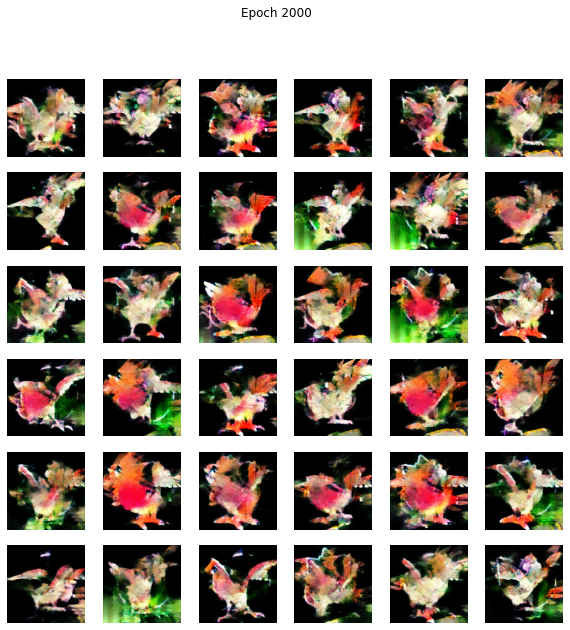

Lossy conversion from float32 to uint8. Range [0.0800018310546875, 254.879638671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 254.88931274414062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 255.0706787109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 255.0479736328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 254.95248413085938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 254.9892578125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0800018310546875, 254.89010620117188]. Co

In [3]:
pokemon_class_1 = ['Spearow']

for pokemon in pokemon_class_1:
    train_dataset = create_dataset("./PokemonData/" + str(pokemon) + "/*")
    save = str("./savedData/" + str(pokemon) + "/")
    
    train(train_dataset, epochs=2000, save_after=100, save_URL = save)